In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

In [64]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(os.getcwd(), './data/images_all', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [65]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [66]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   random_state = 2137,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 89696 validation 22424


In [67]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [68]:
all_xray_df['path'] = all_xray_df['Image Index'].map(lambda x: './data/images_all/'+x)

In [69]:
columns=['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis','Hernia','Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']
CLASS_MODE = 'raw'
Y_COL = columns
DIRESTORY = None
X_COL = 'path'
CLASSES = all_labels

train_gen=core_idg.flow_from_dataframe(
                        dataframe=train_df,
                        directory=DIRESTORY,
                        x_col=X_COL,
                        y_col=Y_COL,
                        batch_size=20,
                        color_mode = 'rgb',
                        class_mode=CLASS_MODE,
                        target_size=IMG_SIZE)

valid_gen=core_idg.flow_from_dataframe(
                        dataframe=valid_df,
                        directory=DIRESTORY,
                        x_col=X_COL,
                        y_col=Y_COL,
                        batch_size=64,
                        color_mode = 'rgb',
                        class_mode=CLASS_MODE,
                        target_size=IMG_SIZE)

Found 89696 validated image filenames.
Found 22424 validated image filenames.


In [70]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('|', ','))

In [71]:
from sklearn.preprocessing import MultiLabelBinarizer


classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation',
           'Edema', 'Effusion', 'Emphysema', 
           'Fibrosis', "Infiltration", 'Hernia', 
           "Mass", 'Nodule', 'Pleural_Thickening', 
           'Pneumonia', 'Pneumothorax']

encoder = MultiLabelBinarizer(classes=classes)
labels = encoder.fit_transform([c.split(",") for c in list(all_xray_df["Finding Labels"])])

/home/dymkiewi/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) [''] will be ignored
  .format(sorted(unknown, key=str)))


In [72]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights


class_weights = calculating_class_weights(labels)

In [73]:
import keras.backend as K

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [74]:
from efficientnet.keras import EfficientNetB1
import tensorflow as tf

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from keras.models import Sequential


base_model = EfficientNetB1(input_shape =  (256,256,3), 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dense(128))
multi_disease_model.add(BatchNormalization())
multi_disease_model.add(Activation('relu'))
multi_disease_model.add(Dense(128))
multi_disease_model.add(Activation('relu'))

multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))

multi_disease_model.compile(optimizer = 'adam', loss = get_weighted_loss(class_weights)
                            ,metrics =[tf.keras.metrics.AUC(multi_label=True)])

In [75]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_.hdf5".format('weighted_auc_callback_multilabel_true')

checkpoint = ModelCheckpoint(weight_path, monitor='val_auc_4', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
callbacks_list = [checkpoint, early]

In [52]:
multi_disease_model.load_weights('./weighted_auc_callback_.hdf5')

In [78]:
multi_disease_model.load_weights('./data/xray_class_weights.best.hdf5')

0.7750951021395455


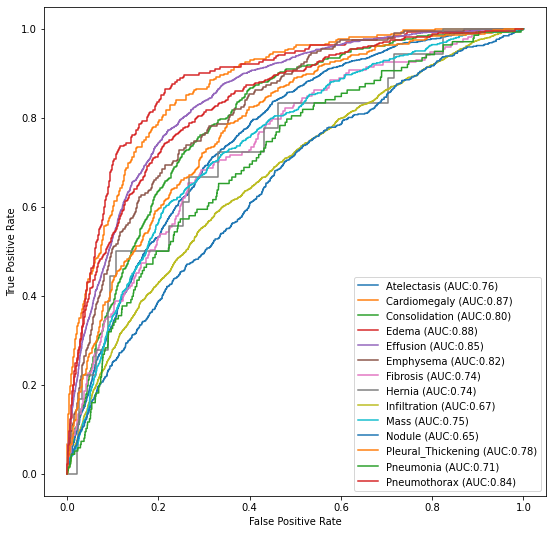

In [22]:
test_X, test_Y = next(core_idg.flow_from_dataframe(
                        dataframe=valid_df,
                        directory=DIRESTORY,
                        x_col=X_COL,
                        y_col=Y_COL,
                        batch_size=11212 ,
                        color_mode = 'rgb',
                        class_mode=CLASS_MODE,
                        target_size=IMG_SIZE)) # one big batch

pred_Y = multi_disease_model.predict(test_X, batch_size = 128, verbose = True)


from sklearn.metrics import roc_curve, auc

avg = []

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    avg.append(auc(fpr, tpr))
    
print(sum(avg) / len(avg))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')
#just to release memory
test_X, test_Y = (0,0)

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=2200,
                                  validation_data = valid_gen, 
#                                   validation_steps=50,
                                  epochs = 100, 
                                  callbacks = callbacks_list)


Epoch 1/100
 304/2200 [===>..........................] - ETA: 16:29 - loss: 0.8337 - auc_4: 0.7068